# Modeling
## Table of Contents
- [Requirements](#requirements)
- [Train-Test Splits](#train-test-splits)
- [PCA](#pca)
- [Model Optimization](#model-optimization)
  - [Linear Regression Model Optimization](#linear-regression-model-optimization)
  - [SVR Model Optimization](#svr-model-optimization)
  - [XGBoost Model Optimization](#xgboost-model-optimization)
- [Conclusion](#conclusion)
  - [Comparing Performance](#comparing-performance)
  - [Reduced Model](#reduced-model)

## Requirements

In [1]:
# imports

import scipy.stats
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from sklearn import metrics
from sklearn.svm import SVR
import statsmodels.api as sm
from sklearn import set_config
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.utils import resample
from sklearn.decomposition import PCA
from matplotlib.ticker import FuncFormatter
from scipy.stats import ttest_rel, wilcoxon
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [2]:
# file reading

df_19 = pd.read_csv('../data/final/1919.csv')
df_95 = pd.read_csv('../data/final/1995.csv')

## Train-Test Splits

In [3]:
# train-test split and data scaling

## instantiate scaler and PCA objects
scaler = StandardScaler()
pca = PCA(0.9)

## create train-test split
# train, test = train_test_split(df_19, test_size=0.2, shuffle=True, random_state=420)
# train = train.sort_values(by='year').reset_index(drop=True)
# test = test.sort_values(by='year').reset_index(drop=True)
# X_train, X_test = train.drop(columns=['grain-yield']), test.drop(columns=['grain-yield'])
# y_train, y_test = train['grain-yield'], test['grain-yield']
X_train, X_test = df_19[df_19['year'] < 2003].drop(columns='grain-yield'), df_19[df_19['year'] >= 2003].drop(columns='grain-yield')
y_train, y_test = df_19[df_19['year'] < 2003]['grain-yield'], df_19[df_19['year'] >= 2003]['grain-yield']

## one hot encoding `state`
encoder = OneHotEncoder(sparse_output=False, drop='first')
state_encoded_train = encoder.fit_transform(X_train[['state']])
state_encoded_test = encoder.transform(X_test[['state']])

## z-score scale the X train and test sets
X_train_scaled = scaler.fit_transform(X_train.drop(columns='state'))
X_test_scaled = scaler.transform(X_test.drop(columns='state'))

## transform the X train and test sets to the PCs
X_train_pc = pca.fit_transform(X_train_scaled)
X_test_pc = pca.transform(X_test_scaled)

## Recombine PCA features and scaled state variables
X_train_pc_e = np.hstack((X_train_pc, state_encoded_train))
X_test_pc_e = np.hstack((X_test_pc, state_encoded_test))

## PCA

Total explained variance: 100.00000000000003


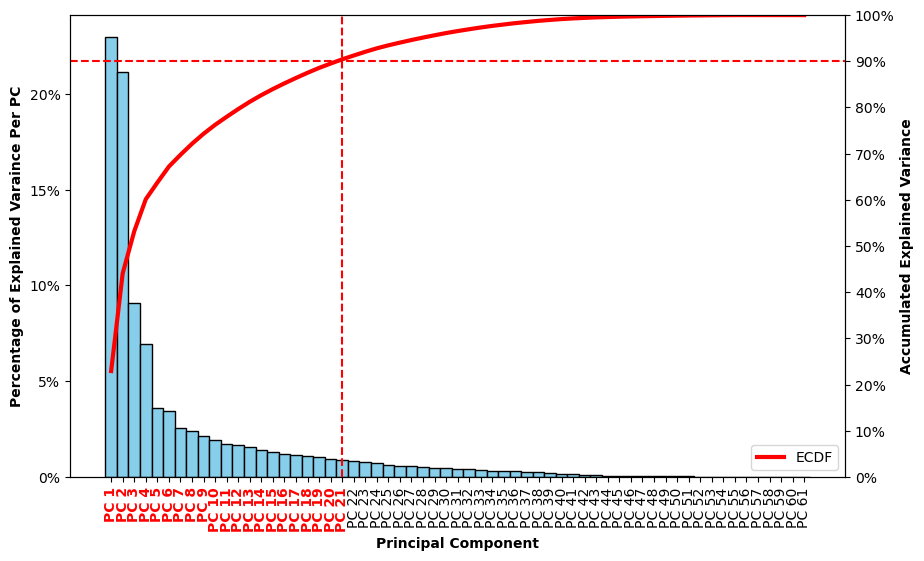

Top 15 features based on cumulative loadings:
Index(['april-avg-temp-lagged', 'november-precipitation-lagged',
       'september-precipitation', 'june-precipitation-lagged', 'april-pdsi',
       'november-pdsi', 'november-pdsi-lagged', 'september-pdsi',
       'april-pdsi-lagged', 'july-precipitation-lagged',
       'october-precipitation', 'july-precipitation', 'november-precipitation',
       'april-precipitation-lagged', 'october-precipitation-lagged'],
      dtype='object')


In [4]:
# making the Scree Plot

## find the total explained variance of PCs
full_pca = PCA()
full_pca.fit(X_train_scaled)
per_var = full_pca.explained_variance_ratio_ * 100
print(f'Total explained variance: {sum(per_var)}')

## plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

labels = ['PC ' + str(x) for x in range(1, len(per_var)+1)]

ax1.bar(
    x=range(1,len(per_var)+1),
    color='skyblue',
    height=per_var,
    width=1,
    edgecolor='black',
    tick_label=labels
)
ax1.set_xticklabels(labels, rotation='vertical')
ax1.set_ylabel('Percentage of Explained Varaince Per PC', fontweight='bold')
ax1.set_xlabel('Principal Component', fontweight='bold')
formatter = FuncFormatter(lambda y, _: f'{int(y)}%')
ax1.yaxis.set_major_formatter(formatter)

cumulative_var = np.cumsum(per_var)

ax2 = ax1.twinx()
ax2.plot(
    range(1, len(cumulative_var) + 1),
    cumulative_var,
    color='red',
    linewidth=3,
    linestyle='-',
)
ax2.axhline(
    y=90,
    color='red',
    linestyle='--'
)
ax2.axvline(
    x=21,
    color='red',
    linestyle='--'
)
ax2.set_ylabel('Accumulated Explained Variance', fontweight='bold')
ax2.legend(['ECDF'], loc='lower right')

formatter = FuncFormatter(lambda y, _: f'{int(y)}%')
ax2.set_ylim(0, 100)
ax2.set_yticks(np.arange(0, 101, 10))
ax2.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)

highlight_indices = [x for x in range(0, 21)]

xticklabels = ax1.get_xticklabels()

for i, label in enumerate(xticklabels):
    if i in highlight_indices:
        label.set_color('red')
        label.set_fontweight('bold')

plt.savefig('../results/scree-plot.png', bbox_inches='tight')
plt.show()

## find the top fifteen features based on total loadings across all PCs
X = df_19.drop(columns=['grain-yield'])
y = df_19['grain-yield']
top_features = np.abs(full_pca.components_).sum(axis=0).argsort()[-15:]
features = X.drop(columns='state').columns[top_features]
print(f'Top 15 features based on cumulative loadings:')
print(features)

## Model Optimization

### Linear Regression Model Optimization

Best model:
   alpha  l1_ratio        r2       rmse
0      0       NaN  0.102335  21.752408


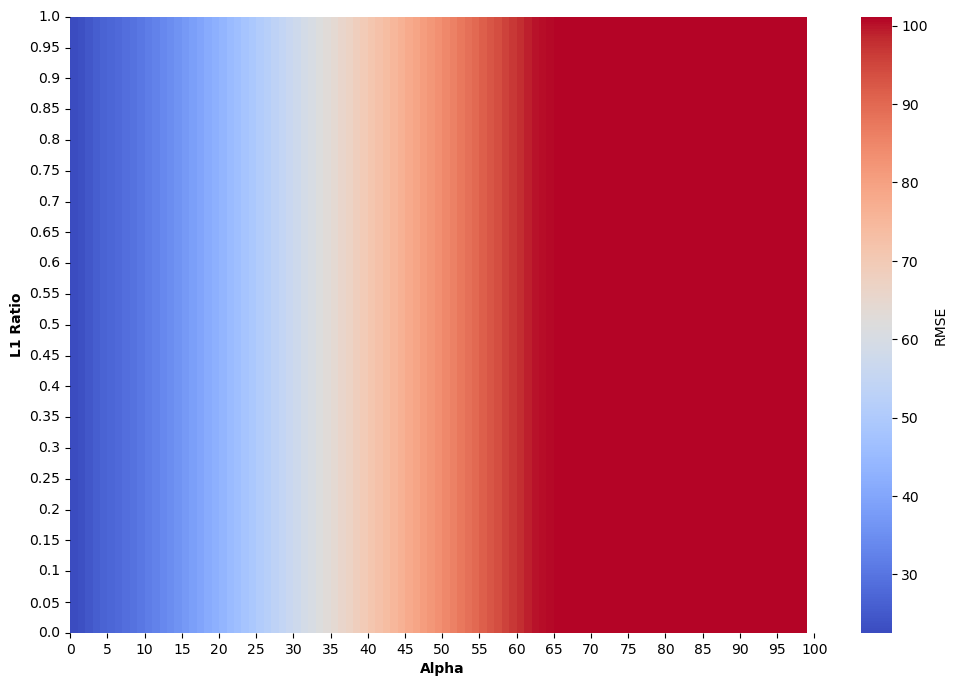

In [5]:
# linear regression model optimization (with L1 penalty)

## generating performance metrics for a range of L1 ratios
metric_list = []
for alpha in np.arange(0, 100, 1):

    if alpha == 0:
        lin_mod = LinearRegression()
        l1_ratio = None

    else:
        for l1_ratio in np.arange(0, 1.00, 0.01):

            if l1_ratio == 0:
                lin_mod = Ridge(
                    alpha=alpha,
                    max_iter=1000
                )

            if l1_ratio == 1:
                lin_mod = Lasso(
                    alpha=alpha,
                    max_iter=1000
                )

            else:
                lin_mod = ElasticNet(
                    alpha=alpha,
                    l1_ratio=l1_ratio,
                    max_iter=1000
                )

    lin_mod.fit(X_train_pc, y_train)
    y_test_pred = lin_mod.predict(X_test_pc)
    r2 = metrics.r2_score(y_test_pred, y_test)
    rmse = metrics.root_mean_squared_error(y_test_pred, y_test)
    metric_list.append([alpha, l1_ratio, r2, rmse])

df_metrics = pd.DataFrame(
    metric_list,
    columns=['alpha', 'l1_ratio', 'r2', 'rmse']
)

## output the lowest RMSE model
print(f'Best model:\n{df_metrics[df_metrics['rmse'] == df_metrics['rmse'].min()]}')

## plotting the performance over the L1 ratio
nan_row_index = df_metrics[(df_metrics['alpha'] == 0) & (df_metrics)['l1_ratio'].isna()].index[0]
df_metrics_temp = df_metrics.drop([nan_row_index])
rmse_matrix = df_metrics_temp.pivot(index='l1_ratio', columns='alpha', values='rmse')

# plotting heatmap
fig = plt.figure(figsize=(12, 8))
sns.heatmap(rmse_matrix, cmap='coolwarm', cbar_kws={'label': 'RMSE'})

plt.gca().invert_yaxis()
y_ticks = np.round(np.arange(0, 1.05, 0.05), 2)
plt.yticks(ticks=y_ticks, labels=y_ticks, rotation=0)

x_ticks = np.arange(0, 105, 5)
plt.xticks(ticks=x_ticks, labels=x_ticks, rotation=0)

plt.xlabel('Alpha', fontweight='bold')
plt.ylabel('L1 Ratio', fontweight='bold')
plt.show()
fig.savefig('../results/linear-regression-optimization.png')

### SVR Model Optimization

In [ ]:
# SVR model optimizer

## instantiate svr model
svr = SVR(kernel='rbf')

## define the parameter distribution
param_dist = {
    'C': np.logspace(-3, 3, 1000),
    'epsilon': np.linspace(0.01, 0.5, 10),
    'gamma': ['scale', 'auto']
}

## instantiate randomizedsearchcv
random_search = RandomizedSearchCV(
    estimator=svr,
    param_distributions=param_dist,
    n_iter=10000,
    cv=5,
    scoring=['neg_root_mean_squared_error', 'r2'],
    n_jobs=-1,
    verbose=1,
    refit='neg_root_mean_squared_error',
    random_state=420
)

## fit and find the best random model
random_search.fit(X_train_pc, y_train)
y_test_pred = random_search.predict(X_test_pc)
print(f'Best parameters : {random_search.best_params_}')
print(f'RMSE: {metrics.root_mean_squared_error(y_test, y_test_pred)}')
print(f'R^2: {metrics.r2_score(y_test, y_test_pred)}\n')

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits
Best parameters : {'gamma': 'scale', 'epsilon': 0.01, 'C': 49.73895958790068}
RMSE: 43.81098100202863
R^2: -2.2162775672580537



### XGBoost Model Optimization

In [ ]:
# SVR model optimizer np.linspace(0.01, 3.0, 10)

## instantiate svr model
xgb = XGBRegressor()

## define the parameter distribution
param_dist = {
    'n_estimators': np.linspace(100, 500, 10).astype(int),
    'learning_rate': np.linspace(0.01, 1, 100),
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 3, 5, 7, 10],
    'subsample': np.linspace(0.6, 1.0, 5),
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'gamma': np.linspace(0.0, 0.4, 5),
    'lambda': np.logspace(0.0, 10.0, 100),
    'alpha': np.logspace(0.0, 10.0, 100),
    'tree_method': ['auto', 'exact', 'approx', 'hist']
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=10000,
    cv=5,
    scoring=['neg_root_mean_squared_error', 'r2'],
    n_jobs=-1,
    verbose=1,
    refit='neg_root_mean_squared_error',
    random_state=420
)

## fit and find the best random model
random_search.fit(X_train_pc, y_train)
y_test_pred = random_search.predict(X_test_pc)
print(f'Best parameters : {random_search.best_params_}')
print(f'RMSE: {metrics.root_mean_squared_error(y_test, y_test_pred)}')
print(f'R^2: {metrics.r2_score(y_test, y_test_pred)}\n')

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits
Best parameters : {'tree_method': 'hist', 'subsample': 0.8, 'n_estimators': 455, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.06999999999999999, 'lambda': 4.0370172585965545, 'gamma': 0.30000000000000004, 'colsample_bytree': 0.7, 'alpha': 1.2618568830660204}
RMSE: 14.233923981910152
R^2: 0.9284584467819929



## Conclusion

### Comparing Performance

In [6]:
## creating X_train for each state
X_temp = pd.DataFrame(X_test_pc_e)

X_illinois = X_temp.iloc[::6].to_numpy()
X_indiana = X_temp.iloc[1::6].to_numpy()
X_iowa = X_temp.iloc[2::6].to_numpy()
X_minnesota = X_temp.iloc[3::6].to_numpy()
X_missouri = X_temp.iloc[4::6].to_numpy()
X_nebraska = X_temp.iloc[5::6].to_numpy()

X_states = [X_illinois, X_indiana, X_iowa, X_minnesota, X_missouri, X_nebraska]

## creating y_true for each state
y_temp = pd.DataFrame(y_test)

y_illinois = y_temp.iloc[::6].to_numpy()
y_indiana = y_temp.iloc[1::6].to_numpy()
y_iowa = y_temp.iloc[2::6].to_numpy()
y_minnesota = y_temp.iloc[3::6].to_numpy()
y_missouri = y_temp.iloc[4::6].to_numpy()
y_nebraska = y_temp.iloc[5::6].to_numpy()

y_states = [y_illinois, y_indiana, y_iowa, y_minnesota, y_missouri, y_nebraska]

illinois_rmse, illinois_r2 = [], []
indiana_rmse, indiana_r2 = [], []
iowa_rmse, iowa_r2 = [], []
minnesota_rmse, minnesota_r2 = [], []
missouri_rmse, missouri_r2 = [], []
nebraska_rmse, nebraska_r2 = [], []
state_rmses = [illinois_rmse, indiana_rmse, iowa_rmse, minnesota_rmse, missouri_rmse, nebraska_rmse]
state_r2s = [illinois_r2, indiana_r2, iowa_r2, minnesota_r2, missouri_r2, nebraska_r2]

In [7]:
# visualizing model performance

## retraining Linear Regression model
lin_model = LinearRegression()
lin_model.fit(X_train_pc_e, y_train)

## retraining SVR model
svr_model = SVR(
    kernel='rbf',
    C=317.32296347349796,
    epsilon=0.01,
    gamma='scale'
)
svr_model.fit(X_train_pc_e, y_train)

## retraining XGBoost model
xgb_model = XGBRegressor(
    alpha=1.2618568830660204,
    colsample_bytree=0.7,
    gamma=0.30000000000000004,
    reg_lambda=4.0370172585965545,
    learning_rate=0.06999999999999999,
    max_depth=3,
    min_child_weight=5,
    n_estimators=455,
    subsample=0.8,
    tree_method='hist'
)
xgb_model.fit(X_train_pc_e, y_train)

## predictions
y_train_pred_lin = lin_model.predict(X_train_pc_e)
y_train_pred_svr = svr_model.predict(X_train_pc_e)
y_train_pred_xgb = xgb_model.predict(X_train_pc_e)

y_test_pred_lin = lin_model.predict(X_test_pc_e)
y_test_pred_svr = svr_model.predict(X_test_pc_e)
y_test_pred_xgb = xgb_model.predict(X_test_pc_e)

## find metrics
print(f'Linear Regression ** Train RMSE: {metrics.root_mean_squared_error(y_train, y_train_pred_lin):.4f}')
print(f'Linear Regression ** Train R2: {metrics.r2_score(y_train, y_train_pred_lin):.4f}')
print(f'Linear Regression ** Test RMSE: {metrics.root_mean_squared_error(y_test, y_test_pred_lin):.4f}')
print(f'Linear Regression ** Test R2: {metrics.r2_score(y_test, y_test_pred_lin):.4f}\n')

print(f'SVR ** Train RMSE: {metrics.root_mean_squared_error(y_train, y_train_pred_svr):.4f}')
print(f'SVR ** Train R2: {metrics.r2_score(y_train, y_train_pred_svr):.4f}')
print(f'SVR ** Test RMSE: {metrics.root_mean_squared_error(y_test, y_test_pred_svr):.4f}')
print(f'SVR ** Test R2: {metrics.r2_score(y_test, y_test_pred_svr):.4f}\n')

print(f'XGBoost ** Train RMSE: {metrics.root_mean_squared_error(y_train, y_train_pred_xgb):.4f}')
print(f'XGBoost ** Train R2: {metrics.r2_score(y_train, y_train_pred_xgb):.4f}')
print(f'XGBoost ** Test RMSE: {metrics.root_mean_squared_error(y_test, y_test_pred_xgb):.4f}')
print(f'XGBoost ** Test R2: {metrics.r2_score(y_test, y_test_pred_xgb):.4f}\n\n')

### for individual states
illinois_preds, indiana_preds, iowa_preds, minnesota_preds, missouri_preds, nebraska_preds = [], [], [], [], [], []
all_preds = [illinois_preds, indiana_preds, iowa_preds, minnesota_preds, missouri_preds, nebraska_preds]

for i, test_set in enumerate(X_states):
    lin_temp = y_test_pred_lin[i::6]
    svr_temp = y_test_pred_svr[i::6]
    xgb_temp = y_test_pred_xgb[i::6]
    all_preds[i] = [lin_temp, svr_temp, xgb_temp]

for i, state_preds in enumerate(all_preds):
    for j in range(3):
        state_rmse = metrics.root_mean_squared_error(y_states[i], state_preds[j])
        state_r2 = metrics.r2_score(y_states[i], state_preds[j])
        state_rmses[i].append(state_rmse)
        state_r2s[i].append(state_r2)

states = ['Illinois', 'Indiana', 'Iowa', 'Minnesota', 'Missouri', 'Nebraska']
models = ['Linear Regression', 'SVR', 'XGBoost']

for i, state in enumerate(states):
    print(f'{state} RMSE: {models[state_rmses[i].index(min(state_rmses[i]))]} ** {min(state_rmses[i]):.4f}')
    print(f'{state} R2: {models[state_r2s[i].index(max(state_r2s[i]))]} ** {max(state_r2s[i]):.4f}\n')

    best_rmse = min(state_rmses[i])
    best_r2 = max(state_r2s[i])

Linear Regression ** Train RMSE: 10.9116
Linear Regression ** Train R2: 0.9213
Linear Regression ** Test RMSE: 20.6481
Linear Regression ** Test R2: 0.2856

SVR ** Train RMSE: 0.1008
SVR ** Train R2: 1.0000
SVR ** Test RMSE: 42.8208
SVR ** Test R2: -2.0725

XGBoost ** Train RMSE: 2.1714
XGBoost ** Train R2: 0.9969
XGBoost ** Test RMSE: 46.0457
XGBoost ** Test R2: -2.5528


Illinois RMSE: Linear Regression ** 24.4443
Illinois R2: Linear Regression ** 0.1184

Indiana RMSE: Linear Regression ** 24.9577
Indiana R2: Linear Regression ** -0.1622

Iowa RMSE: Linear Regression ** 18.7615
Iowa R2: Linear Regression ** -0.0228

Minnesota RMSE: Linear Regression ** 15.3832
Minnesota R2: Linear Regression ** -0.0368

Missouri RMSE: Linear Regression ** 23.3252
Missouri R2: Linear Regression ** 0.1958

Nebraska RMSE: Linear Regression ** 14.3157
Nebraska R2: Linear Regression ** 0.0797



In [8]:
years = list(range(1919, 2025))*6
years.sort()
t_critical = stats.t.ppf(1 - .1 / 2, df=len(X_train) - 62 - 1)
train_years = df_19[df_19['year'] < 2003]['year']
test_years = df_19[df_19['year'] >= 2003]['year']

## prediction interval for linear regression model
residuals_lin = y_train - y_train_pred_lin
SE_lin = np.sqrt(np.mean(residuals_lin**2))

prediction_intervals = []
for i in range(len(X_train)):
    train_lower = y_train_pred_lin[i] - t_critical * SE_lin
    train_upper = y_train_pred_lin[i] + t_critical * SE_lin
    prediction_intervals.append([train_lower, train_upper])
for i in range(len(X_test)):
    test_lower = y_test_pred_lin[i] - t_critical * SE_lin
    test_upper = y_test_pred_lin[i] + t_critical * SE_lin
    prediction_intervals.append([test_lower, test_upper])

df_interval_lin = pd.DataFrame(
    prediction_intervals,
    columns=['lower_bound', 'upper_bound']
)
df_interval_lin['year'] = years

## prediction interval for SVR model
residuals_svr = y_train - y_train_pred_svr
SE_svr = np.sqrt(np.mean(residuals_svr**2))

prediction_intervals = []
for i in range(len(X_train)):
    train_lower = y_train_pred_svr[i] - t_critical * SE_lin
    train_upper = y_train_pred_svr[i] + t_critical * SE_lin
    prediction_intervals.append([i+1919, train_lower, train_upper])
for i in range(len(X_test)):
    test_lower = y_test_pred_svr[i] - t_critical * SE_lin
    test_upper = y_test_pred_svr[i] + t_critical * SE_lin
    prediction_intervals.append([i+2003, test_lower, test_upper])

df_interval_svr = pd.DataFrame(
    prediction_intervals,
    columns=['year', 'lower_bound', 'upper_bound']
)
df_interval_svr['year'] = years

## prediction interval for XGBoost model
residuals_xgb = y_train - y_train_pred_xgb
SE_xgb = np.sqrt(np.mean(residuals_xgb**2))

prediction_intervals = []
for i in range(len(X_train)):
    train_lower = y_train_pred_xgb[i] - t_critical * SE_lin
    train_upper = y_train_pred_xgb[i] + t_critical * SE_lin
    prediction_intervals.append([i+1919, train_lower, train_upper])
for i in range(len(X_test)):
    test_lower = y_test_pred_xgb[i] - t_critical * SE_lin
    test_upper = y_test_pred_xgb[i] + t_critical * SE_lin
    prediction_intervals.append([i+2003, test_lower, test_upper])

df_interval_xgb = pd.DataFrame(
    prediction_intervals,
    columns=['year', 'lower_bound', 'upper_bound']
)
df_interval_xgb['year'] = years

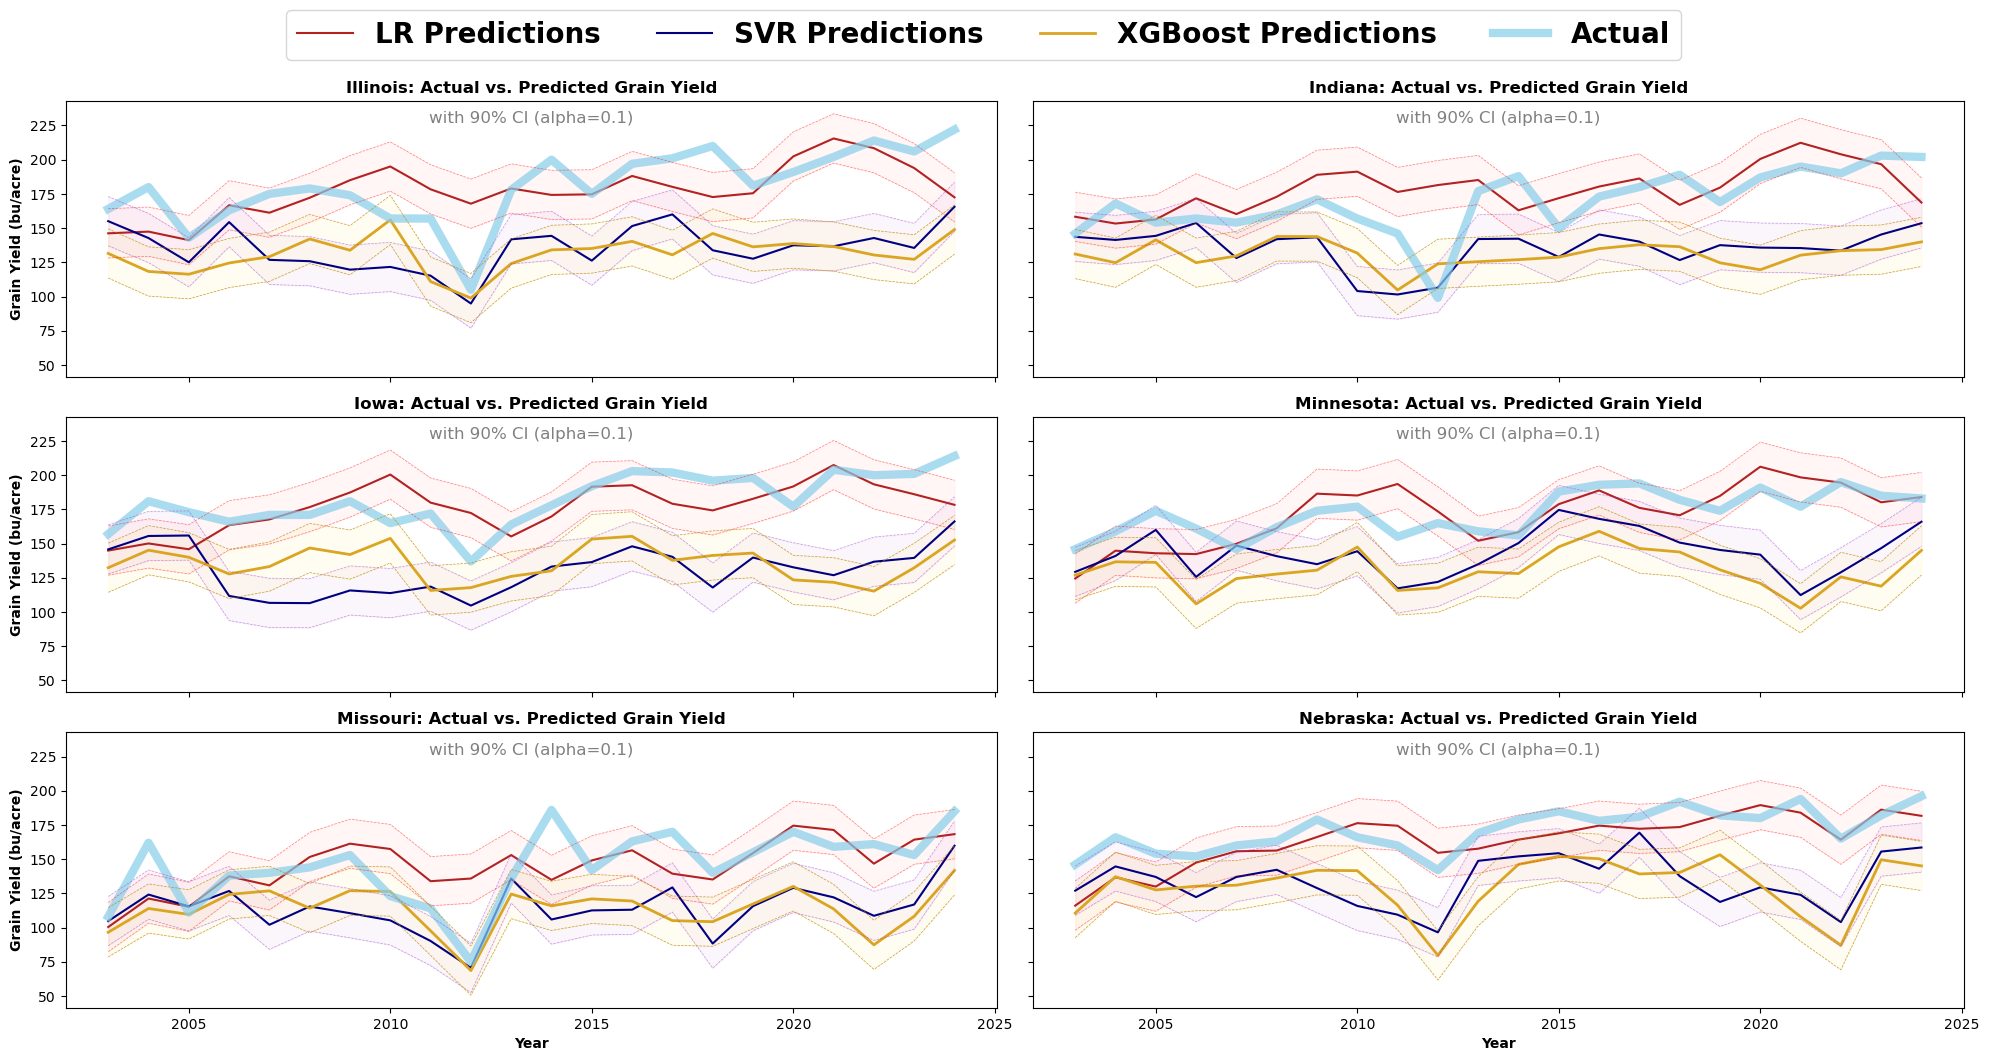

In [12]:
lin_illinois_int = df_interval_lin[df_interval_lin['year'] >= 2003].iloc[::6]
lin_indiana_int = df_interval_lin[df_interval_lin['year'] >= 2003].iloc[1::6]
lin_iowa_int = df_interval_lin[df_interval_lin['year'] >= 2003].iloc[2::6]
lin_minnesota_int = df_interval_lin[df_interval_lin['year'] >= 2003].iloc[3::6]
lin_missouri_int = df_interval_lin[df_interval_lin['year'] >= 2003].iloc[4::6]
lin_nebraska_int = df_interval_lin[df_interval_lin['year'] >= 2003].iloc[5::6]
lin_intervals = [lin_illinois_int, lin_indiana_int, lin_iowa_int, lin_minnesota_int, lin_missouri_int, lin_nebraska_int]

svr_illinois_int = df_interval_svr[df_interval_svr['year'] >= 2003].iloc[::6]
svr_indiana_int = df_interval_svr[df_interval_svr['year'] >= 2003].iloc[1::6]
svr_iowa_int = df_interval_svr[df_interval_svr['year'] >= 2003].iloc[2::6]
svr_minnesota_int = df_interval_svr[df_interval_svr['year'] >= 2003].iloc[3::6]
svr_missouri_int = df_interval_svr[df_interval_svr['year'] >= 2003].iloc[4::6]
svr_nebraska_int = df_interval_svr[df_interval_svr['year'] >= 2003].iloc[5::6]
svr_intervals = [svr_illinois_int, svr_indiana_int, svr_iowa_int, svr_minnesota_int, svr_missouri_int, svr_nebraska_int]

xgb_illinois_int = df_interval_xgb[df_interval_xgb['year'] >= 2003].iloc[::6]
xgb_indiana_int = df_interval_xgb[df_interval_xgb['year'] >= 2003].iloc[1::6]
xgb_iowa_int = df_interval_xgb[df_interval_xgb['year'] >= 2003].iloc[2::6]
xgb_minnesota_int = df_interval_xgb[df_interval_xgb['year'] >= 2003].iloc[3::6]
xgb_missouri_int = df_interval_xgb[df_interval_xgb['year'] >= 2003].iloc[4::6]
xgb_nebraska_int = df_interval_xgb[df_interval_xgb['year'] >= 2003].iloc[5::6]
xgb_intervals = [xgb_illinois_int, xgb_indiana_int, xgb_iowa_int, xgb_minnesota_int, xgb_missouri_int, xgb_nebraska_int]

fig, axes = plt.subplots(3, 2, figsize=(20, 10), sharex=True, sharey=True)
for i, state in enumerate(states):

    if i == 4 or i == 5:
        xlabel = 'Year'
    else:
        xlabel = ''

    if i == 0 or i == 2 or i == 4:
        ylabel = 'Grain Yield (bu/acre)'
    else:
        ylabel = ''

    ax = axes[i // 2, i % 2]

    y_true = y_states[i]
    lin_predictions = [state_preds[0] for state_preds in all_preds][i]
    svr_predictions = [state_preds[1] for state_preds in all_preds][i]
    xgb_predictions = [state_preds[2] for state_preds in all_preds][i]

    plt.subplot(3, 2, i+1)

    ## plotting model predictions
    plt.plot(
        test_years.unique(),
        lin_predictions,
        color='firebrick',
        label='LR Predictions'
    )
    plt.plot(
        test_years.unique(),
        svr_predictions,
        color='navy',
        label='SVR Predictions'
    )
    plt.plot(
        test_years.unique(),
        xgb_predictions,
        color='goldenrod',
        label='XGBoost Predictions',
        linewidth=2
    )

    ## plotting true values
    plt.plot(
        test_years.unique(),
        y_true,
        color='skyblue',
        linewidth=6,
        label='Actual',
        alpha=0.7
    )

    ## plotting model intervals

    ### plotting interval fills
    plt.fill_between(
        lin_intervals[i]['year'],
        lin_intervals[i]['lower_bound'],
        lin_intervals[i]['upper_bound'],
        color='mistyrose',
        alpha=0.3
    )
    plt.fill_between(
        svr_intervals[i]['year'],
        svr_intervals[i]['lower_bound'],
        svr_intervals[i]['upper_bound'],
        color='mediumorchid',
        alpha=0.05
    )
    plt.fill_between(
        xgb_intervals[i]['year'],
        xgb_intervals[i]['lower_bound'],
        xgb_intervals[i]['upper_bound'],
        color='gold',
        alpha=0.05
    )

    ### plotting interval borders
    plt.plot(
        lin_intervals[i]['year'],
        lin_intervals[i]['upper_bound'],
        color='red',
        linestyle='--',
        linewidth=0.5,
        alpha=0.5
    )
    plt.plot(
        lin_intervals[i]['year'],
        lin_intervals[i]['lower_bound'],
        color='red',
        linestyle='--',
        linewidth=0.5,
        alpha=0.5
    )

    plt.plot(
        svr_intervals[i]['year'],
        svr_intervals[i]['upper_bound'],
        color='darkorchid',
        linestyle='--',
        linewidth=0.5,
        alpha=0.5
    )
    plt.plot(
        svr_intervals[i]['year'],
        svr_intervals[i]['lower_bound'],
        color='darkorchid',
        linestyle='--',
        linewidth=0.5,
        alpha=0.5
    )

    plt.plot(
        xgb_intervals[i]['year'],
        xgb_intervals[i]['upper_bound'],
        color='darkgoldenrod',
        linestyle='--',
        linewidth=0.5,
        alpha=0.8
    )
    plt.plot(
        xgb_intervals[i]['year'],
        xgb_intervals[i]['lower_bound'],
        color='darkgoldenrod',
        linestyle='--',
        linewidth=0.5,
        alpha=0.8
    )

    ax.set_title(f'{states[i]}: Actual vs. Predicted Grain Yield', fontweight='bold')
    ax.text(0.5, 0.92, 'with 90% CI (alpha=0.1)', fontsize=12, color='gray', ha='center', transform=plt.gca().transAxes)
    ax.set_xlabel(xlabel, fontweight='bold')
    ax.set_ylabel(ylabel, fontweight='bold')

handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles, 
    labels,
    ncol=4,
    bbox_to_anchor=(0.85, 1.07),
    prop={'weight': 'bold', 'size':20}
)

fig.tight_layout()
fig.savefig('../results/state-forecasts.png', bbox_inches='tight')

### Reduced Model

In [13]:
## computing variable importance
coefficients = lin_model.coef_
coefficients_pca = coefficients[:len(pca.explained_variance_ratio_)]
coefficients_state = coefficients[len(pca.explained_variance_ratio_):]

explained_variance_ratios = pca.explained_variance_ratio_
adjusted_coefficients_pca = coefficients_pca * explained_variance_ratios
variable_importance = np.dot(pca.components_.T, adjusted_coefficients_pca)

variable_names = list(X_train.drop(columns=['year', 'state']).columns)
variable_importance_normalized = variable_importance / np.sum(np.abs(variable_importance))

var_importance = []
for name, normalized_importance, importance in zip(variable_names, variable_importance_normalized, variable_importance):
    var_importance.append([name, importance, normalized_importance])
df_var_importance = pd.DataFrame(
    var_importance,
    columns=['variable', 'importance', 'normalized_importance']
)

df_var_importance.sort_values(
    by='normalized_importance',
    ascending=False,
    inplace=True,
    ignore_index=True
)

In [14]:
metrics_list = []

for i in range(1, 61):

    temp_mod = LinearRegression()

    reduced_columns = list(df_var_importance.head(i)['variable'])
    reduced_columns.append('year')
    reduced_columns.append('state')

    X_temp = df_19[reduced_columns]
    X_train_temp = X_temp.iloc[:504]
    X_test_temp = X_temp.iloc[504:]

    temp_encoder = OneHotEncoder(sparse_output=False, drop='first')
    train_temp_encoded = temp_encoder.fit_transform(X_train_temp[['state']])
    test_temp_encoded = temp_encoder.transform(X_test_temp[['state']])
    X_train_temp = np.hstack((X_train_temp.drop(columns='state'), train_temp_encoded))
    X_test_temp = np.hstack((X_test_temp.drop(columns='state'), test_temp_encoded))

    temp_scaler = StandardScaler()
    X_train_temp = temp_scaler.fit_transform(X_train_temp)
    X_test_temp = temp_scaler.transform(X_test_temp)

    temp_mod.fit(X_train_temp, y_train)
    y_test_pred_temp = temp_mod.predict(X_test_temp)

    temp_rmse, temp_mape, temp_r2 = metrics.root_mean_squared_error(y_test, y_test_pred_temp), metrics.mean_absolute_percentage_error(y_test, y_test_pred_temp), metrics.r2_score(y_test, y_test_pred_temp)
    metrics_list.append([i, temp_rmse, temp_mape, temp_r2])

df_metrics = pd.DataFrame(
    metrics_list,
    columns=['num_var', 'rmse', 'mape', 'r2']
)

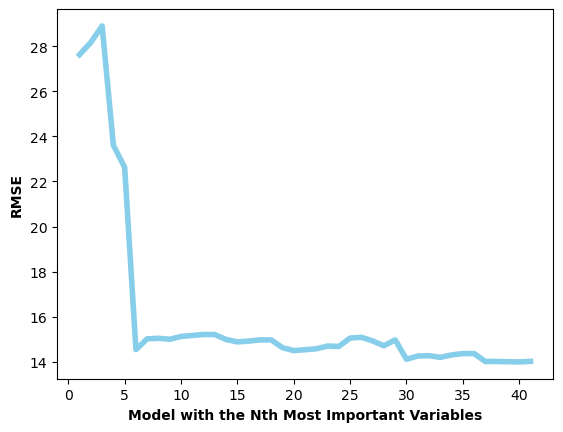

In [15]:
plt.plot(
    df_metrics[df_metrics['num_var'] < 42]['num_var'],
    df_metrics[df_metrics['num_var'] < 42]['rmse'],
    color='skyblue',
    linewidth=4
)
plt.xlabel('Model with the Nth Most Important Variables', fontweight='bold')
plt.ylabel('RMSE', fontweight='bold')
plt.savefig('../results/performance-vs-n-variables.png')

In [16]:
reduced_mod = LinearRegression()

reduced_columns = df_var_importance.head(6)['variable']
X_reduced = df_19[reduced_columns]
X_train_reduced = X_reduced.iloc[:504]
X_test_reduced = X_reduced.iloc[504:]

reduced_scaler = StandardScaler()
X_train_reduced = reduced_scaler.fit_transform(X_train_reduced)
X_test_reduced = reduced_scaler.transform(X_test_reduced)

reduced_mod.fit(X_train_reduced, y_train)
y_test_pred_reduced = reduced_mod.predict(X_test_reduced)

In [17]:
print(f'Reduced model RMSE: {metrics.root_mean_squared_error(y_test, y_test_pred_reduced)}')
print(f'Reduced model R^2: {metrics.r2_score(y_test, y_test_pred_reduced)}')
print(f'Reduced model MAPE: {metrics.mean_absolute_percentage_error(y_test, y_test_pred_reduced)}')

Reduced model RMSE: 14.633149151546442
Reduced model R^2: 0.6411911350775596
Reduced model MAPE: 0.06971146923220702


In [18]:
errors_full = y_test - y_test_pred_lin
errors_reduced = y_test - y_test_pred_reduced

t_stat, p_value_t = ttest_rel(errors_full, errors_reduced, alternative='less')
w_stat, p_value_w = wilcoxon(errors_full, errors_reduced, alternative='less')

print(f'Paired t-test p-value: {p_value_t}')
print(f'Wilcoxon signed-rank test p-value: {p_value_w}')

def calculate_aic_sklearn(model, X, y):
    y_pred = model.predict(X)
    rss = np.sum((y - y_pred) ** 2)
    n = len(y)
    k = X.shape[1] + 1
    log_likelihood = -n / 2 * (np.log(2 * np.pi) + 1 + np.log(rss / n))
    aic = 2 * k - 2 * log_likelihood
    return aic

lin_aic = calculate_aic_sklearn(lin_model, X_train_pc_e, y_train)
reduced_aic = calculate_aic_sklearn(reduced_mod, X_train_reduced, y_train)

print(f'Full model training set AIC: {lin_aic}')
print(f'Reduced model training set AIC: {reduced_aic}')

def calculate_bic_sklearn(model, X, y):
    y_pred = model.predict(X)
    rss = np.sum((y - y_pred) ** 2)
    n = len(y)
    k = X.shape[1] + 1
    log_likelihood = -n / 2 * (np.log(2 * np.pi) + 1 + np.log(rss / n))
    bic = k * np.log(n) - 2 * log_likelihood
    return bic

lin_bic = calculate_bic_sklearn(lin_model, X_train_pc_e, y_train)
reduced_bic = calculate_bic_sklearn(reduced_mod, X_train_reduced, y_train)

print(f'Full model training set BIC: {lin_bic}')
print(f'Reduced model training set BIC: {reduced_bic}')

Paired t-test p-value: 0.013762169984728564
Wilcoxon signed-rank test p-value: 0.06460654352891784
Full model training set AIC: 3893.2318143231396
Reduced model training set AIC: 3487.8429548620475
Full model training set BIC: 4007.2413735610667
Reduced model training set BIC: 3517.400988738547


/var/folders/j7/fswh0x992tzfxgs898w7vv9w0000gn/T/ipykernel_60189/345975614.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(
/var/folders/j7/fswh0x992tzfxgs898w7vv9w0000gn/T/ipykernel_60189/345975614.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(


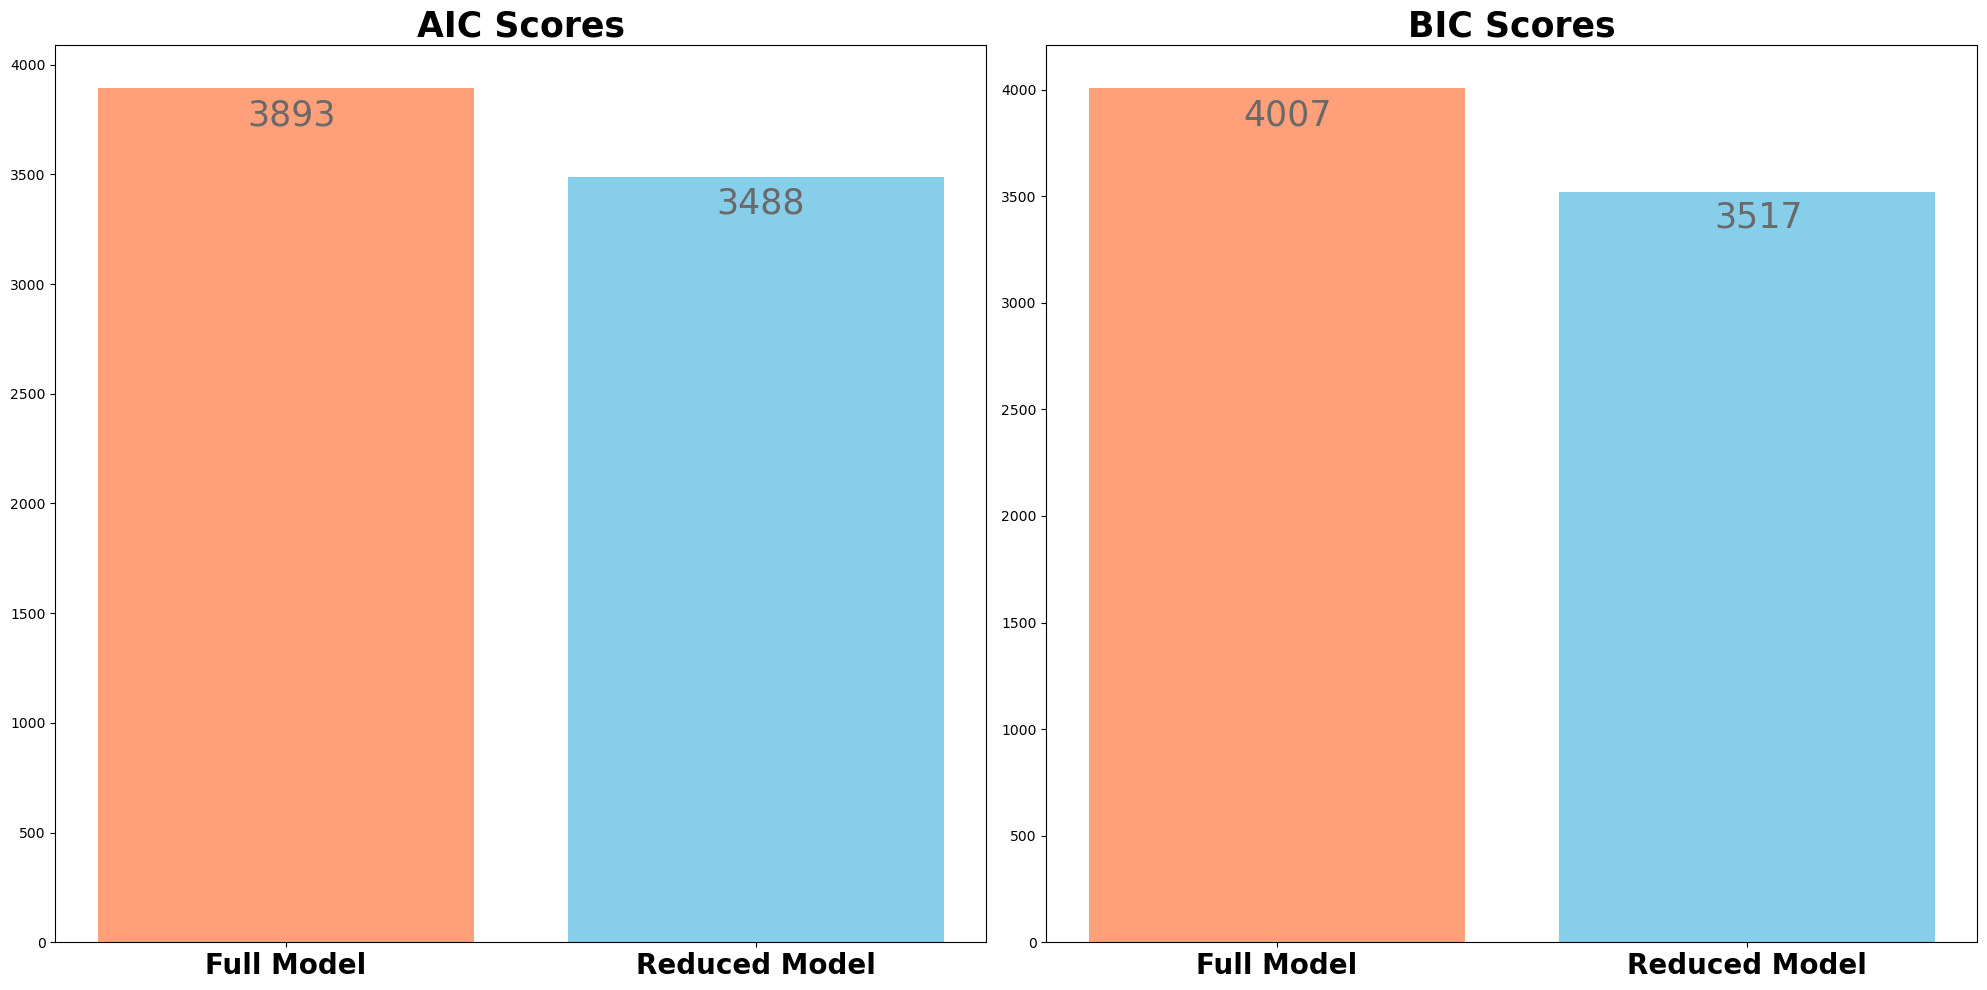

In [19]:
aic_scores = np.array([lin_aic, reduced_aic])
bic_scores = np.array([lin_bic, reduced_bic])

ecolors = ['red', 'blue']
colors = ['lightsalmon', 'skyblue']

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].bar(
    x=['Full Model', 'Reduced Model'],
    height=aic_scores,
    color=colors
)
axes[0].set_title(
    'AIC Scores',
    fontweight='bold',
    fontsize=25
)
axes[0].set_xticklabels(
    ['Full Model', 'Reduced Model'],
    fontweight='bold',
    fontsize=20
)
axes[0].text(
    0.215, 1.75,
    round(aic_scores[0]),
    fontsize=25,
    color='dimgray',
    horizontalalignment='center',
    verticalalignment='center',
    transform=ax1.transAxes
)
axes[0].text(
    0.82, 1.56,
    round(aic_scores[1]),
    fontsize=25,
    color='dimgray',
    horizontalalignment='center',
    verticalalignment='center',
    transform=ax1.transAxes
)

axes[1].bar(
    x=['Full Model', 'Reduced Model'],
    height=bic_scores,
    color=colors
)
axes[1].set_title(
    'BIC Scores',
    fontweight='bold',
    fontsize=25
)
axes[1].set_xticklabels(
    ['Full Model', 'Reduced Model'],
    fontweight='bold',
    fontsize=20
)
axes[1].text(
    1.5, 1.75,
    round(bic_scores[0]),
    fontsize=25,
    color='dimgray',
    horizontalalignment='center',
    verticalalignment='center',
    transform=ax1.transAxes
)
axes[1].text(
    2.108, 1.53,
    round(bic_scores[1]),
    fontsize=25,
    color='dimgray',
    horizontalalignment='center',
    verticalalignment='center',
    transform=ax1.transAxes
)

fig.tight_layout()
fig.savefig('../results/aic-bic-comparison.png')

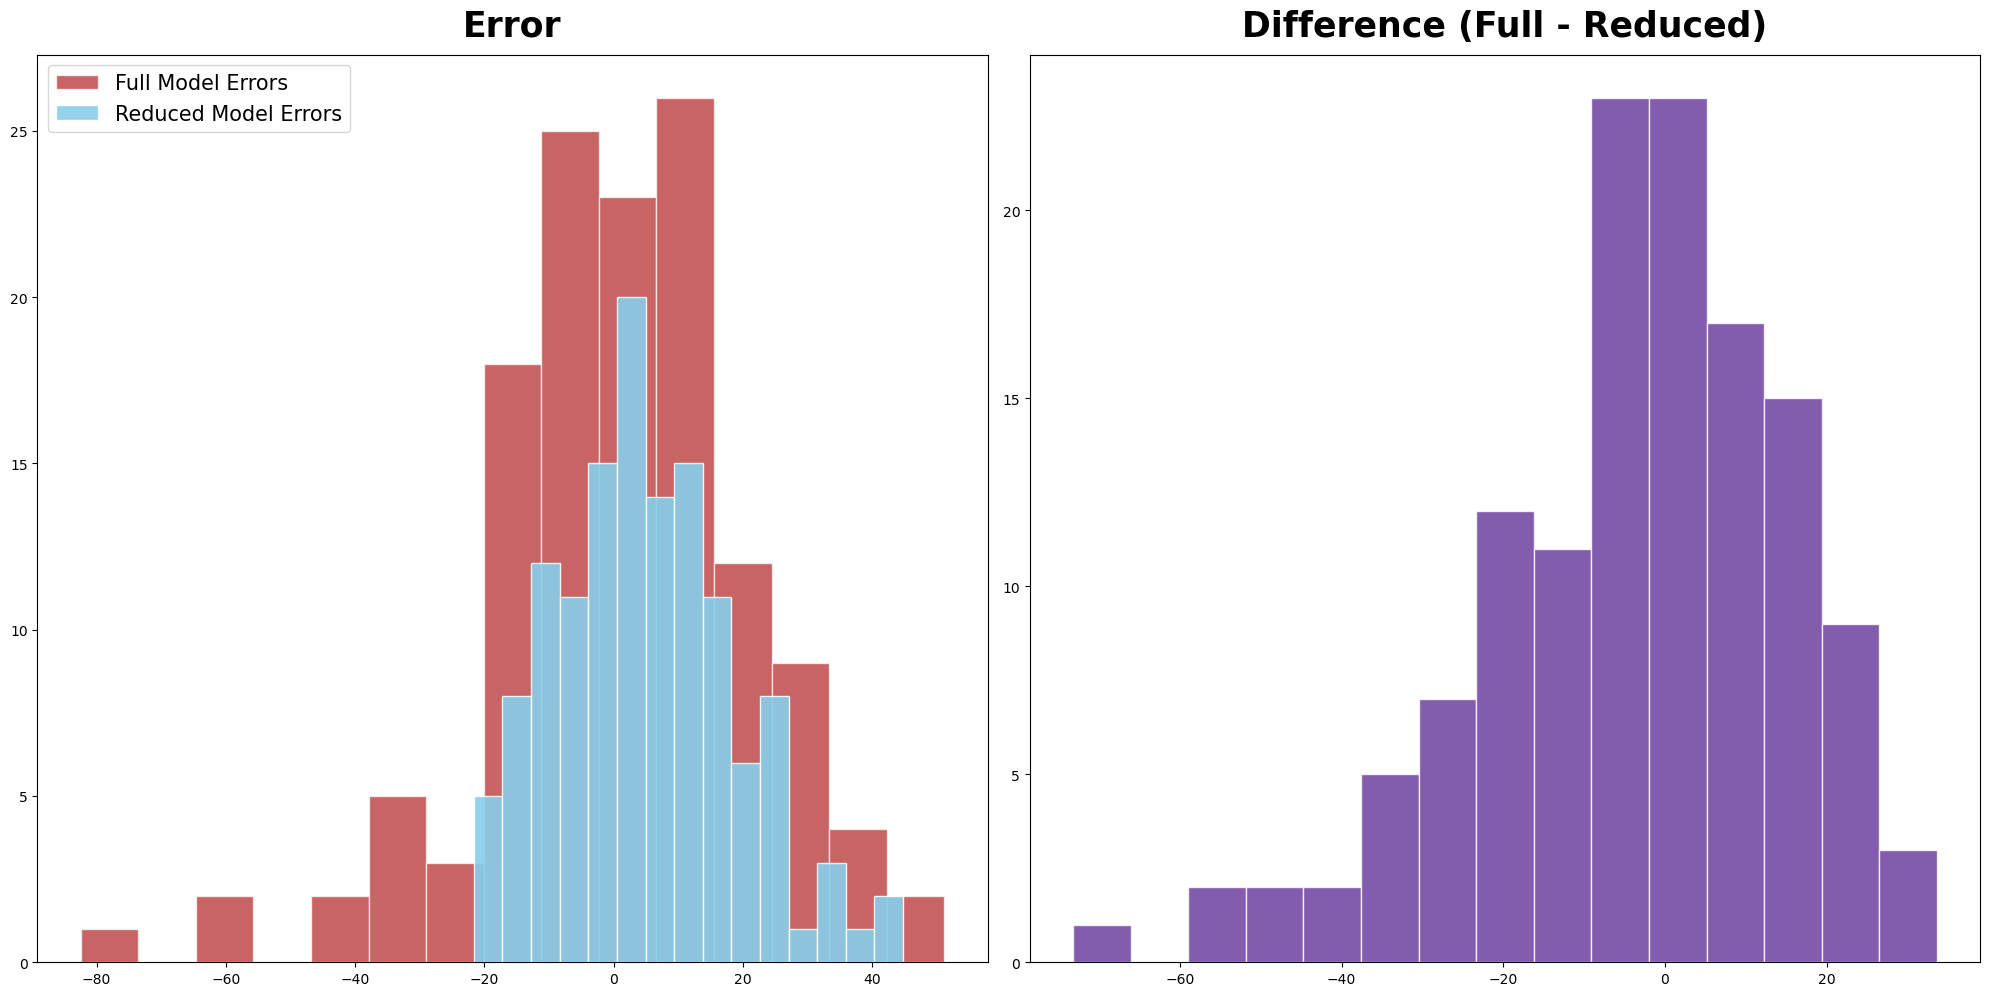

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
bins = 15

# Histogram of individual errors
axes[0].hist(
    errors_full,
    color='firebrick',
    bins=bins,
    alpha=0.7,
    label='Full Model Errors',
    edgecolor='white'
)
axes[0].hist(
    errors_reduced,
    color='skyblue',
    bins=bins,
    alpha=0.9,
    label='Reduced Model Errors',
    edgecolor='white'
)
axes[0].set_xlabel('Error', fontweight='bold', fontsize=25)
axes[0].xaxis.set_label_coords(0.5, 1.05)
axes[0].set_ylabel('')
axes[0].legend(
    loc='upper left',
    bbox_to_anchor=(0, 1),
    prop={'size':15}
)

# Histogram of error differences
axes[1].hist(
    errors_full - errors_reduced,
    color='rebeccapurple',
    bins=bins,
    alpha=0.8,
    edgecolor='white'
)
axes[1].set_xlabel('Difference (Full - Reduced)', fontweight='bold', fontsize=25)
axes[1].xaxis.set_label_coords(0.5, 1.05)
axes[1].set_ylabel('')

# Adjust layout and show
plt.tight_layout()
fig.savefig('../results/wilcoxon.png')
plt.show()

/var/folders/j7/fswh0x992tzfxgs898w7vv9w0000gn/T/ipykernel_60189/3904382567.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


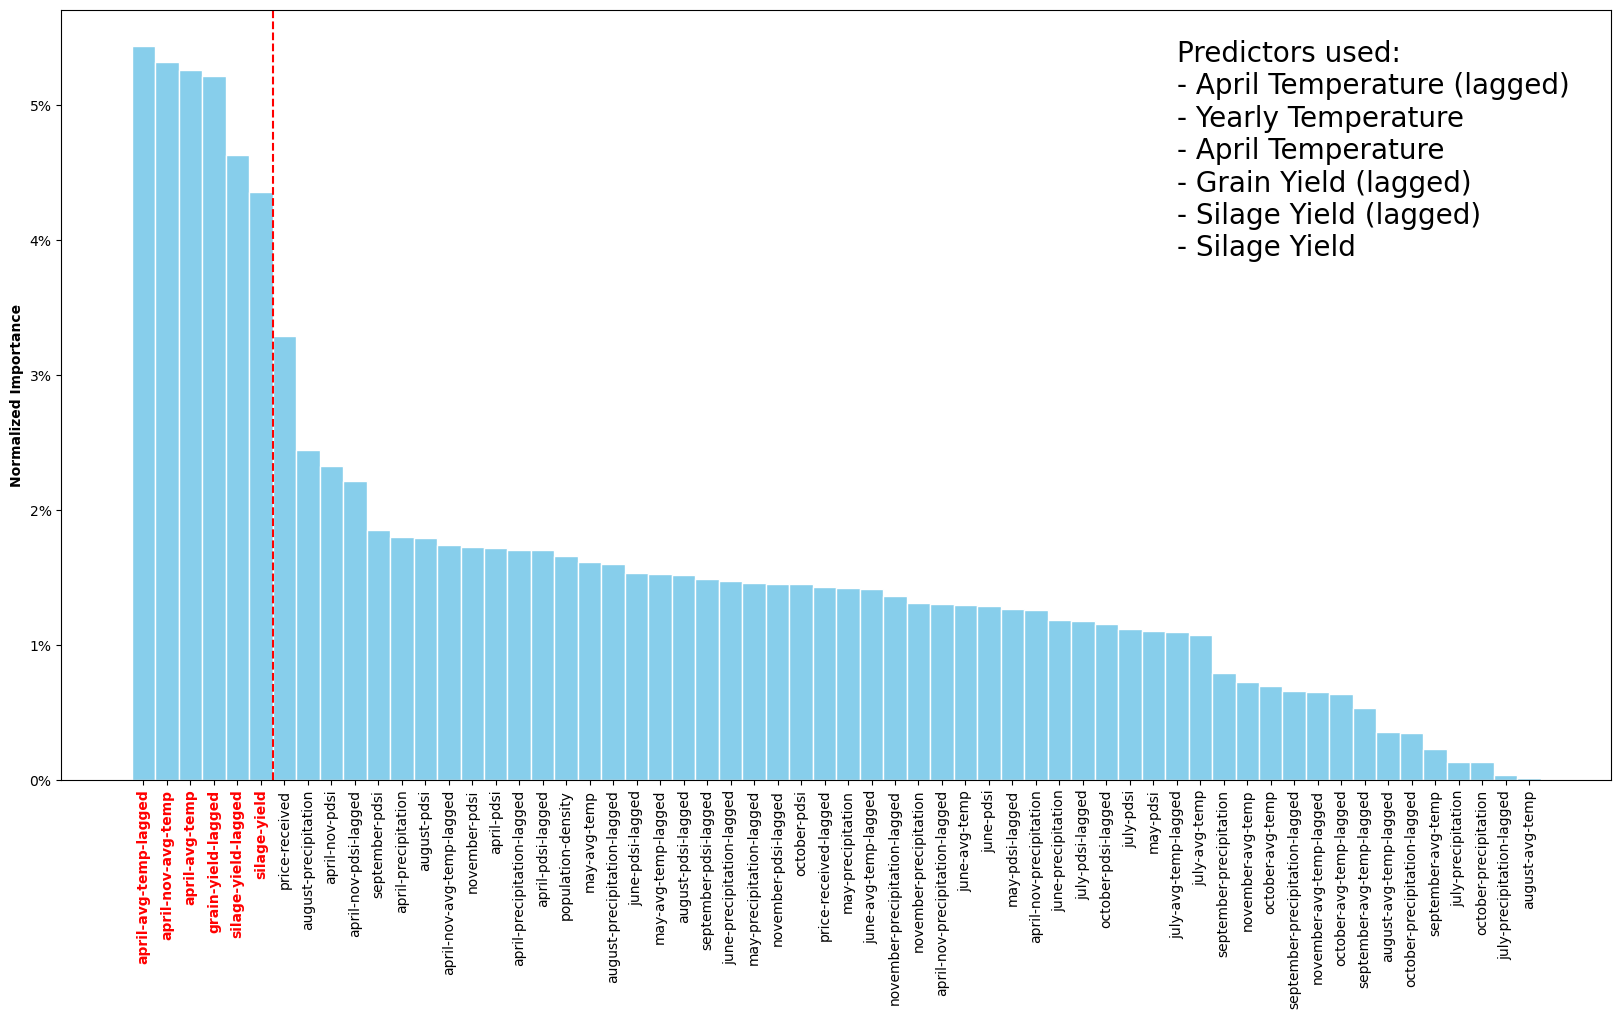

In [21]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(
    df_var_importance['variable'],
    df_var_importance['normalized_importance'],
    color='skyblue',
    width=1,
    edgecolor='white'
)
ax.set_xticklabels(
    labels=df_var_importance['variable'],
    rotation='vertical'
)
formatter = FuncFormatter(lambda y, _: f'{round(y*100)}%')
ax.yaxis.set_major_formatter(formatter)
ax.set_ylabel(
    'Normalized Importance',
    fontweight='bold'
)

highlight_indices = [x for x in range(0, 6)]
xticklabels = ax.get_xticklabels()
for i, label in enumerate(xticklabels):
    if i in highlight_indices:
        label.set_color('red')
        label.set_fontweight('bold')

ax.axvline(
    x=5.5,
    color='red',
    linestyle='--'
)

ax.text(0.72, 0.68,
        f'Predictors used:\n- April Temperature (lagged)\n- Yearly Temperature\n- April Temperature\n- Grain Yield (lagged)\n- Silage Yield (lagged)\n- Silage Yield',
        fontsize=20, ha='left', transform=plt.gca().transAxes
)

fig.savefig('../results/normalized-importance.png')
plt.show()

In [22]:
illinois_preds, indiana_preds, iowa_preds, minnesota_preds, missouri_preds, nebraska_preds = [], [], [], [], [], []
all_preds = [illinois_preds, indiana_preds, iowa_preds, minnesota_preds, missouri_preds, nebraska_preds]

for i, test_set in enumerate(X_states):
    reduced_temp = y_test_pred_reduced[i::6]
    all_preds[i] = [reduced_temp]

t_critical = stats.t.ppf(1 - .01 / 2, df=len(X_train) - 6 - 1)
train_years = df_19[df_19['year'] < 2003]['year']
test_years = df_19[df_19['year'] >= 2003]['year']

y_train_pred_reduced = reduced_mod.predict(X_train_reduced)

residuals_reduced = y_train - y_train_pred_reduced
SE_lin = np.sqrt(np.mean(residuals_reduced**2))

prediction_intervals = []
for i in range(len(X_train)):
    train_lower = y_train_pred_reduced[i] - t_critical * SE_lin
    train_upper = y_train_pred_reduced[i] + t_critical * SE_lin
    prediction_intervals.append([train_lower, train_upper])
for i in range(len(X_test)):
    test_lower = y_test_pred_reduced[i] - t_critical * SE_lin
    test_upper = y_test_pred_reduced[i] + t_critical * SE_lin
    prediction_intervals.append([test_lower, test_upper])

df_interval_reduced = pd.DataFrame(
    prediction_intervals,
    columns=['lower_bound', 'upper_bound']
)
df_interval_reduced['year'] = years

reduced_illinois_int = df_interval_reduced[df_interval_reduced['year'] >= 2003].iloc[::6]
reduced_indiana_int = df_interval_reduced[df_interval_reduced['year'] >= 2003].iloc[1::6]
reduced_iowa_int = df_interval_reduced[df_interval_reduced['year'] >= 2003].iloc[2::6]
reduced_minnesota_int = df_interval_reduced[df_interval_reduced['year'] >= 2003].iloc[3::6]
reduced_missouri_int = df_interval_reduced[df_interval_reduced['year'] >= 2003].iloc[4::6]
reduced_nebraska_int = df_interval_reduced[df_interval_reduced['year'] >= 2003].iloc[5::6]
reduced_intervals = [reduced_illinois_int, reduced_indiana_int, reduced_iowa_int, reduced_minnesota_int, reduced_missouri_int, reduced_nebraska_int]

In [23]:
ci_pct = []
for j in range(len(states)):
    in_ci = []
    for i in range(len(y_true)):
        # get bounds
        upper = list(reduced_intervals[j]['upper_bound'])
        lower = list(reduced_intervals[j]['lower_bound'])
        # check if value lies between CI bounds
        value = y_states[j].flatten()[i]
        if (value < upper[i]) & (value > lower[i]):
            in_ci.append(True)
        else:
            in_ci.append(False)
    ci_pct.append(sum(in_ci)/len(in_ci))

ci_pct

[0.7727272727272727,
 0.9545454545454546,
 0.9090909090909091,
 1.0,
 0.7272727272727273,
 0.6818181818181818]

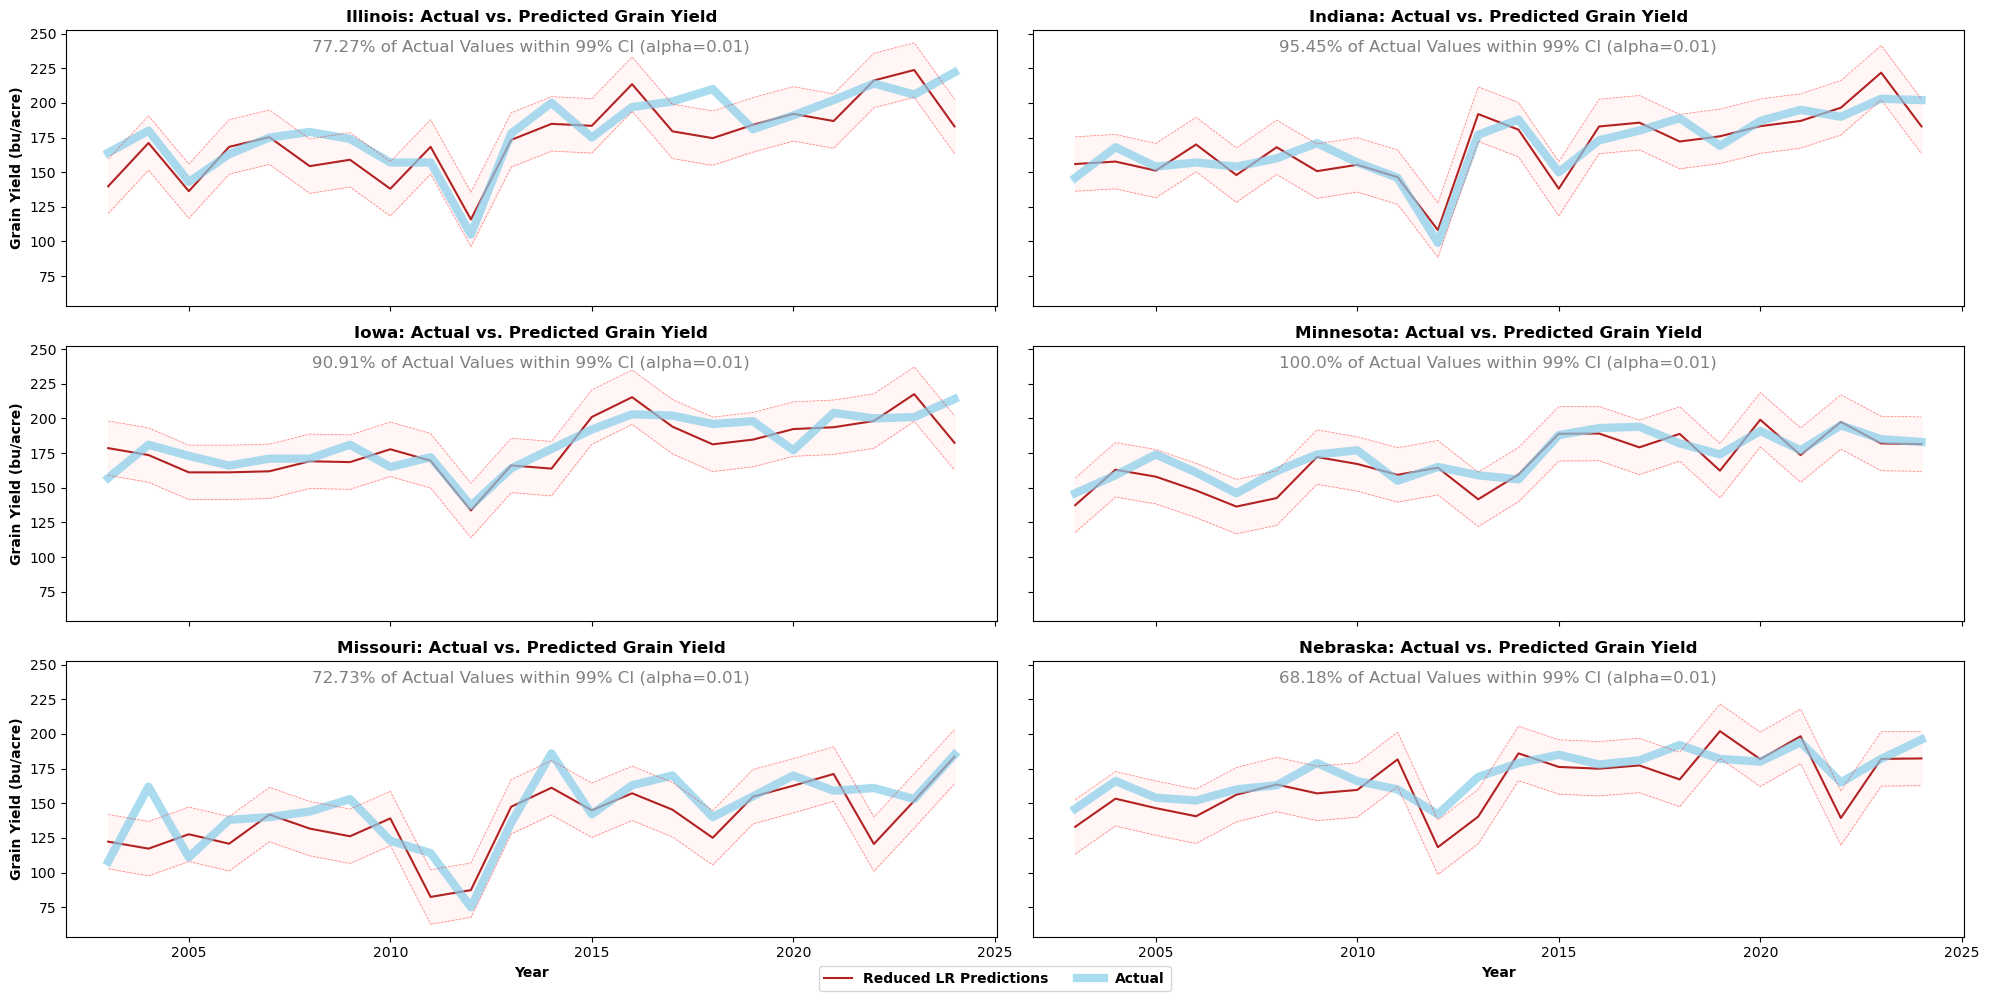

In [24]:
fig, axes = plt.subplots(3, 2, figsize=(20, 10), sharex=True, sharey=True)

for i, state in enumerate(states):

    if i == 4 or i == 5:
        xlabel = 'Year'
    else:
        xlabel = ''

    if i == 0 or i == 2 or i == 4:
        ylabel = 'Grain Yield (bu/acre)'
    else:
        ylabel = ''

    ax = axes[i // 2, i % 2]

    y_true = y_states[i]
    reduced_predictions = all_preds[i][0]

    plt.subplot(3, 2, i+1)

    ## plotting model predictions
    plt.plot(
        test_years.unique(),
        reduced_predictions,
        color='firebrick',
        label='Reduced LR Predictions'
    )

    ## plotting true values
    plt.plot(
        test_years.unique(),
        y_true,
        color='skyblue',
        linewidth=6,
        label='Actual',
        alpha=0.7
    )

    ## plotting model intervals

    ### plotting interval fills
    plt.fill_between(
        reduced_intervals[i]['year'],
        reduced_intervals[i]['lower_bound'],
        reduced_intervals[i]['upper_bound'],
        color='mistyrose',
        alpha=0.3
    )

    ### plotting interval borders
    plt.plot(
        reduced_intervals[i]['year'],
        reduced_intervals[i]['upper_bound'],
        color='red',
        linestyle='--',
        linewidth=0.5,
        alpha=0.5
    )
    plt.plot(
        reduced_intervals[i]['year'],
        reduced_intervals[i]['lower_bound'],
        color='red',
        linestyle='--',
        linewidth=0.5,
        alpha=0.5
    )

    ax.set_title(f'{states[i]}: Actual vs. Predicted Grain Yield', fontweight='bold')
    ax.text(0.5, 0.92, f'{np.round(ci_pct[i]*100, 2)}% of Actual Values within 99% CI (alpha=0.01)', fontsize=12, color='gray', ha='center', transform=plt.gca().transAxes)
    ax.set_xlabel(xlabel, fontweight='bold')
    ax.set_ylabel(ylabel, fontweight='bold')

handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles, 
    labels, 
    loc='lower center', 
    ncol=4,
    prop={'weight': 'bold'}
)

fig.tight_layout()
fig.savefig('../results/state-forecasts-reduced.png')